In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [55]:
# mturk csv file to analyze
mturk_csv_path = './data_files/mturk/moderation0.csv'

# read contents into dataframe
mturk_df = pd.read_csv(mturk_csv_path)

In [159]:
# helper method to create a bar chart
def plot(values, x_labels, y_label='', title=''):
    colors = ['red', 'blue', 'green', 'orange', 'yellow', 'purple'][0:len(x_labels)]
    x_pos = list(range(len(x_labels)))
    
    fig, ax = plt.subplots()
    ax.grid(linestyle='dashed')
    ax.bar(x_pos, values, width=0.6, color=colors, align='center')
    
    for bar, value in zip(ax.patches, values):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                str(value)[:6], ha='center', va='bottom')
    
    plt.ylabel(y_label)
    plt.xticks(x_pos, x_labels)
    plt.title(title)
    plt.show()

In [160]:
# calculate worker accuracy
def calc_accuracy():
    # get expert labels
    with open('../image_processing/labels.json') as handle:
        expert_labels = json.load(handle)
        handle.close()

    # evaluate accuracy wrt. individual categories and overall
    num_total_correct_category = 0
    num_total_category = 0
    num_error = 0
    num_other = 0

    num_sexnudity_correct = 0
    num_sexnudity_incorrect = 0

    num_graphic_correct = 0
    num_graphic_incorrect = 0

    num_safe_correct = 0
    num_safe_incorrect = 0

    # evaluate accuracy wrt. individual types and overall
    num_total_correct_type = 0
    num_total_type = 0

    num_realistic_correct = 0
    num_realistic_incorrect = 0

    num_synthetic_correct = 0
    num_synthetic_incorrect = 0

    # evaluate accuracy wrt. both category and type
    num_total_correct = 0
    num_total = 0

    # iterate through worker submissions
    for row in mturk_df.itertuples():
        labels = getattr(row, 'labels')
        worker_labels = json.loads(labels)

        # iterate through worker annotations for each image
        for image, annotation in worker_labels.items():
            # skip if no annotations for this image
            if annotation == 'error':
                num_error += 1
                continue

            worker_category = annotation['category']
            worker_type = annotation['type']
            worker_label_type = worker_category + '_' + worker_type

            expert_annotation = expert_labels[image]
            expert_category = expert_annotation['category']
            expert_type = expert_annotation['type']
            expert_label_type = expert_annotation['label_type']

            # evaluate accuracy wrt. category
            if worker_category == 'other':
                num_other += 1
            else:
                if worker_category == expert_category:
                    if expert_category == 'sex_nudity':
                        num_sexnudity_correct += 1
                    elif expert_category == 'graphic':
                        num_graphic_correct += 1
                    else:
                        num_safe_correct += 1
                    num_total_correct_category += 1
                else:
                    if expert_category == 'sex_nudity':
                        num_sexnudity_incorrect += 1
                    elif expert_category == 'graphic':
                        num_graphic_incorrect += 1
                    else:
                        num_safe_incorrect += 1    
                num_total_category += 1

            # evaluate wrt. type
            if worker_type == expert_type:
                if expert_type == 'realistic':
                    num_realistic_correct += 1
                else:
                    num_synthetic_correct += 1
                num_total_correct_type += 1
            else:
                if expert_type == 'realistic':
                    num_realistic_incorrect += 1
                else:
                    num_synthetic_incorrect += 1
            num_total_type += 1

            # evaluate wrt. both category and type
            if worker_category == 'other':
                pass
            else:
                num_total += 1
                if worker_label_type == expert_label_type:
                    num_total_correct += 1

    # calculate and print results wrt. categories
    accuracy_values = []
    accuracy_labels = []
    
    print('Category accuracy:')
    
    v = num_total_correct_category / num_total_category
    accuracy_values.append(v)
    accuracy_labels.append('All categories')
    print('\tOverall detection:\t{}'.format(v))
    
    if num_sexnudity_correct + num_sexnudity_incorrect:
        v = num_sexnudity_correct / (num_sexnudity_correct + num_sexnudity_incorrect)
        accuracy_values.append(v)
        accuracy_labels.append('Sex and nudity')
        print('\tSex and nudity detection:\t{}'.format(v))
    
    if num_graphic_correct + num_graphic_incorrect:
        v = num_graphic_correct / (num_graphic_correct + num_graphic_incorrect)
        accuracy_values.append(v)
        accuracy_labels.append('Graphic content')
        print('\tGraphic content detection:\t{}'.format(v))
    
    if num_safe_correct + num_safe_incorrect:
        v = num_safe_correct / (num_safe_correct + num_safe_incorrect)
        accuracy_values.append(v)
        accuracy_labels.append('Safe content')
        print('\tSafe content detection:\t{}'.format(v))
        
    plot(accuracy_values, accuracy_labels, 'Accuracy', 'Category Detection')
    print('\n')

    # calculate and print results wrt. types
    type_values = []
    type_labels = []
    
    print('Type accuracy:')
    
    v = num_total_correct_type / num_total_type
    type_values.append(v)
    type_labels.append('All types')
    print('\tOverall detection:\t{}'.format(v))
    
    if num_realistic_correct + num_realistic_incorrect:
        v = num_realistic_correct / (num_realistic_correct + num_realistic_incorrect)
        type_values.append(v)
        type_labels.append('Realistic')
        print('\tRealistic detection:\t{}'.format(v))
    
    if num_synthetic_correct + num_synthetic_incorrect:
        v = num_synthetic_correct / (num_synthetic_correct + num_synthetic_incorrect)
        type_values.append(v)
        type_labels.append('Synthetic')
        print('\tSynthetic detection:\t{}'.format(v))
    
    plot(type_values, type_labels, 'Accuracy', 'Type Detection')
    print('\n')

    # calculate and print results wrt. both category and type
    print('Category and type accuracy:')
    print('\tOverall detection:\t{}'.format(num_total_correct / num_total))
    print('\n')

    # print number of 'other' category annotations and number of 'errors' reported
    print('Number of images skipped:')
    print('\tNumber of errored images:\t\t{}'.format(num_error))
    print('\tNumber of "other" categorizations:\t{}'.format(num_other))

In [161]:
# calculate worker confidence statistics
def calc_confidence():
    confidences = []

    # iterate through worker submissions
    for row in mturk_df.itertuples():
        labels = getattr(row, 'labels')
        worker_labels = json.loads(labels)

        # iterate through worker annotations for each image
        for image, annotation in worker_labels.items():
            # skip if no annotations for this image
            if annotation == 'error':
                continue

            confidences.append(annotation['confidence'])

    # convert list to np array
    confidences = np.asarray(confidences, dtype=np.float64)

    # calculate and print statistics
    print('Confidence statistics:')
    print('\tAverage:\t{}'.format(np.mean(confidences)))
    print('\tStandard dev:\t{}'.format(np.std(confidences)))

In [162]:
# calculate worker behavioral statistics
def calc_behavioral():
    # calculate and print clicks_total statistics
    clicks_total = mturk_df['clicks_total']
    print('Clicks total:')
    print('\tAverage:\t{}'.format(np.mean(clicks_total)))
    print('\tStandard dev:\t{}'.format(np.std(clicks_total)))
    print('\n')

    # calculate and print mousemove_total statistics
    mousemoves_total = mturk_df['mousemoves_total']
    print('Mousemoves total:')
    print('\tAverage:\t{}'.format(np.mean(mousemoves_total)))
    print('\tStandard dev:\t{}'.format(np.std(mousemoves_total)))
    print('\n')

    # calculate and print completion_time statistics
    completion_time = mturk_df['completion_time']
    print('Completion time:')
    print('\tAverage:\t{}'.format(np.mean(completion_time)))
    print('\tStandard dev:\t{}'.format(np.std(completion_time)))

Category accuracy:
	Overall detection:	0.9230769230769231
	Safe content detection:	0.9230769230769231


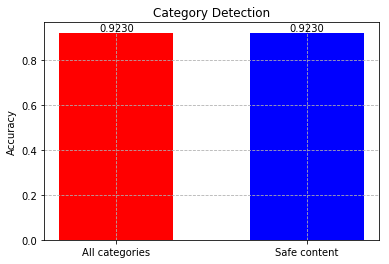



Type accuracy:
	Overall detection:	0.9
	Realistic detection:	0.9777777777777777
	Synthetic detection:	0.8533333333333334


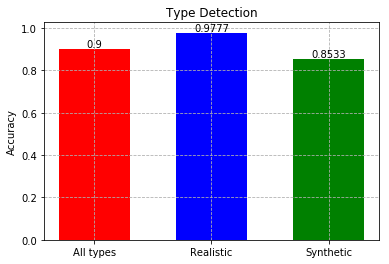



Category and type accuracy:
	Overall detection:	0.8290598290598291


Number of images skipped:
	Number of errored images:		0
	Number of "other" categorizations:	3


In [163]:
calc_accuracy()

In [8]:
calc_confidence()

Confidence statistics:
	Average:	4.625
	Standard dev:	0.5174053858758462


In [10]:
calc_behavioral()

Clicks total:
	Average:	83.91666666666667
	Standard dev:	17.269714981885357


Mousemoves total:
	Average:	94.16666666666667
	Standard dev:	34.28029884480135


Completion time:
	Average:	179050.75
	Standard dev:	55985.063660058775
